In [14]:
import sys
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import sleep
from sklearn import preprocessing
#naive bayes classifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import datasets  
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm

In [15]:
import lightgbm as lgb
lgb.LGBMClassifier()

LGBMClassifier()

In [16]:
from sklearn.datasets import make_classification

In [122]:
num_features = 2
num_info = 2

In [216]:
X, y = make_classification(n_samples = 500, n_informative=2, n_features=5, flip_y = 0.1, random_state=0)

In [234]:
X_df = pd.DataFrame(X, columns=['Feature'+str(i+1) for i in range(5)])
X_df['y']=y
X_df

,Feature1,Feature2,Feature3,Feature4,Feature5,y
0,-0.979565,-1.244990,0.181934,-0.130440,-0.568629,1
1,-1.044279,-0.168034,0.295844,-0.522619,2.262452,1
2,0.884519,0.328589,-0.234212,-1.446578,-1.455390,1
3,-0.681383,-1.156319,0.101036,-1.097497,-1.113952,0
4,-0.815404,0.164488,0.256994,-0.537583,2.498333,0
...,...,...,...,...,...,...
495,0.136995,-0.186848,-0.057171,0.298977,-0.813742,1
496,-1.041639,-1.889393,0.143757,0.033090,-2.004115,0
497,-0.109766,-0.197389,0.015299,-1.998639,-0.206955,0
498,-1.504845,-0.837039,0.374032,-0.326318,1.788107,0


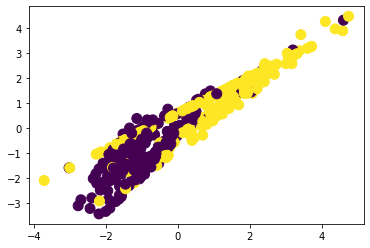

In [218]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100);

In [227]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [229]:
def lgb_evaluate(numLeaves, maxDepth, scaleWeight, minChildWeight, subsample, colSam, output = 'score'):
    reg=lgb.LGBMRegressor(num_leaves=31, max_depth= 2,scale_pos_weight= scaleWeight, min_child_weight= minChildWeight, subsample= 0.4, colsample_bytree= 0.4, learning_rate=0.05,   n_estimators=20)
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='roc_auc')
    # scores = cross_val_score(reg, train_x, train_y, cv=5, scoring='neg_mean_squared_error')
 
    if output == 'score':
        return np.mean(scores)
    if output == 'model':
        return reg

In [230]:
def bayesOpt(train_x, train_y):
    lgbBO = BayesianOptimization(lgb_evaluate, {'numLeaves':(5, 90), 'maxDepth':(2, 90),
                                                'scaleWeight':(1, 10000), 'minChildWeight':(0.01, 70), 
                                                'subsample': (0.4, 1), 'colSam': (0.4, 1)})
    lgbBO.maximize(init_points=5, n_iter=30)
    print(lgbBO.res)
    return lgbBO

In [237]:
from sklearn.model_selection import train_test_split

X, y = np.array(X_df.drop('y',axis=1)), np.array(X_df['y'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [242]:
lgbBO = bayesOpt(X_train, y_train)

|   iter    |  target   |  colSam   | maxDepth  | minChi... | numLeaves | scaleW... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.843    |  0.7551   |  58.87    |  59.02    |  63.62    |  3.688e+0 |  0.8735   |
|  2        |  0.8427   |  0.6927   |  26.95    |  16.4     |  11.25    |  8.647e+0 |  0.9671   |
|  3        |  0.8427   |  0.4417   |  55.88    |  17.33    |  70.62    |  5.818e+0 |  0.8199   |
|  4        |  0.8449   |  0.6414   |  45.29    |  44.81    |  33.62    |  745.3    |  0.8296   |
|  5        |  0.8409   |  0.4626   |  89.93    |  66.49    |  89.46    |  4.264e+0 |  0.4911   |
|  6        |  0.8489   |  0.4503   |  46.98    |  41.94    |  35.88    |  750.5    |  0.5323   |
|  7        |  0.8449   |  0.9561   |  41.97    |  44.53    |  50.26    |  754.9    |  0.9349   |
|  8        |  0.8449   |  0.4569   |  41.56    |  44.58    |  36.62    |  754.0    |  0.6129   |
|  9        |  0.844

In [243]:
params = lgbBO.max['params']
params

{'colSam': 0.4503130954061274,
 'maxDepth': 46.983204552033534,
 'minChildWeight': 41.936593743701145,
 'numLeaves': 35.878290931289094,
 'scaleWeight': 750.4624715203443,
 'subsample': 0.5323431921629369}

In [244]:
model = lgb_evaluate(
     numLeaves = params['numLeaves'],
     maxDepth = params['maxDepth'],
     scaleWeight = params['maxDepth'],
     minChildWeight = params['minChildWeight'],
     subsample = params['subsample'],
     colSam = params['colSam'],
     output = 'model'
     )

In [248]:
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, max_depth=2,
              min_child_weight=41.936593743701145, n_estimators=20,
              scale_pos_weight=46.983204552033534, subsample=0.4)